### Here we are providing a script where you can extract road graphs from OSM and compute the loads locally.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import osmnx as ox

from src import RoadNetwork as rn
from src import TrafficCentrality as tc
from src import EffectiveVelocities as ev
from src import SupportFunctions as sf


### Creating a RoadNetwork of Heidelberg, leaving out "residential" and "unclassified" roads.

In [3]:
driving_tags = [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
]
highway_filter = f"w/highway={','.join(driving_tags)}"

HD = rn.RoadNetwork(
    osmpbf="germany.osm.pbf",
    highway_filter=highway_filter,
    place="Heidelberg,Germany",
)

# combine edge names together
HD.edges["name"] = HD.edges["name"].combine_first(HD.edges["ref"])


/Users/jonas/miniconda3/envs/op311/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


num(nodes)= 576
num(edges)= 1068


### Compute load values locally. Set cpu_cores=N to run on N cpu_cores. Leave cache=False, otherwise it will save the values and return them in further computations.

In [4]:
HD.loads("travel_time", cache=False, cpu_cores=5)


Time: 0.5 seconds


### Compute the effective rerouting velocities of every road with an occupancy paramter of 0.05.

In [5]:
HD.effective_spillover_velocities(gamma=0.05)


### Remove the street with the name "" and compute the loads and the effective velocities

In [6]:
removed_roads = HD.edges[
    HD.edges["name"].astype("str").str.contains("Carl-Benz-Straße")
]
HD.remove_edges(removed_roads.index)

Gr = tc.interaction_betweenness_centrality(HD.graph_r, "travel_time", cache=False)
Gr = ev.effective_spillover_velocities(Gr, 0.05)


Time: 1.4 seconds


Text(0.5, 0, '$\\Delta \\rho_{i j}t_{i j} [\\mathrm{hour}]$')

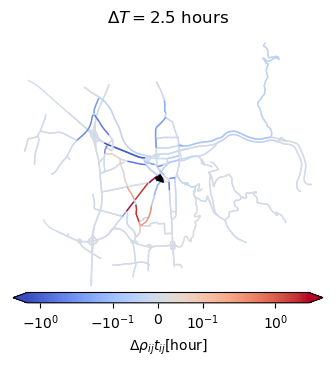

In [7]:
nodes_r, edges_r = ox.graph_to_gdfs(Gr)
edges_r["data"] = (
    (
        edges_r["spillover_travel_time"] * edges_r["spillover_load"]
        - HD.edges["spillover_travel_time"] * HD.edges["spillover_load"]
    )
    / 60
    / 60
)
# %%
fig, ax = plt.subplots(figsize=(6, 4))
ax.grid()
ax.axis("off")

delta_T = round(sf.finite_sum(edges_r["data"]), 1)
ax.set_title(rf"$\Delta T = {delta_T}$ hours")

edges_r["absdata"] = np.abs(edges_r["data"])

linthresh = 0.15e0
vmin = min(edges_r["data"])
vmax = max(np.abs(edges_r[np.isfinite(edges_r["data"])]["data"]))

xmin, ymin, xmax, ymax = HD.edges[
    np.abs(edges_r["data"]) > linthresh
].unary_union.bounds

norm = mpl.colors.SymLogNorm(linthresh, vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("coolwarm")

edges_r[(edges_r["removed"] == True)].plot(ax=ax, color="black", linewidth=5, zorder=3)
edges_r.sort_values(by="absdata", ascending=True).plot(
    ax=ax, column="data", linewidth=1, cmap=cmap, norm=norm
)

scalar_mapper_b = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(
    scalar_mapper_b,
    ax=ax,
    location="bottom",
    extend="both",
    pad=-0.02,
    aspect=30,
    shrink=2 / 3,
)
cbar.ax.set_xlabel(r"$\Delta \rho_{i j}t_{i j} [\mathrm{hour}]$")
